In [1]:
import numpy as np
import cv2
import glob
import os
from CarDetection_HOG_adding_features import display
from skimage import io, data
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

In [2]:
def calibrate():
    
    vi, vj = 9, 6
    
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((vi*vj,3), np.float32)
    objp[:,:2] = np.mgrid[0:vi,0:vj].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    
    images = glob.glob(os.getcwd() +'\\chess\\*.jpg')

    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (vi, vj),None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (vi, vj), corners2,ret)
            display(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False)
            cv2.waitKey(500)

    cv2.destroyAllWindows()
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)    
    
    return ret, mtx, dist, rvecs, tvecs

In [3]:
def undistort(img, mtx, dist):
    #h,  w = img.shape[:2]
    #newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    
    # undistort
    #dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # crop the image
    #x,y,w,h = roi
    #dst = dst[y:y+h, x:x+w]
    
    return dst

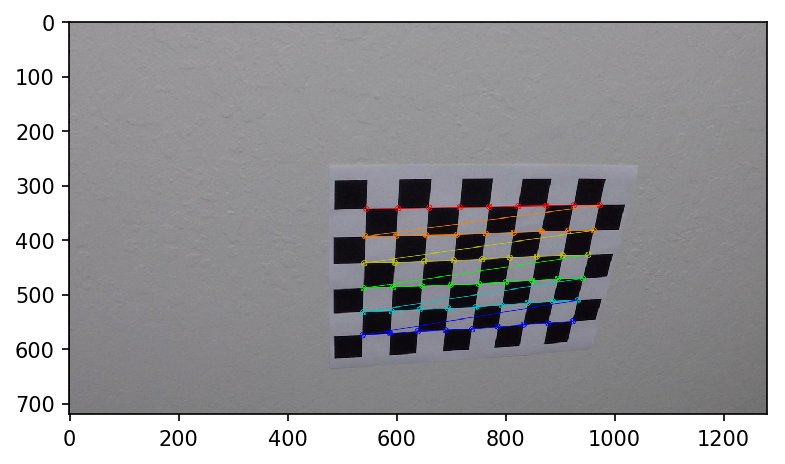

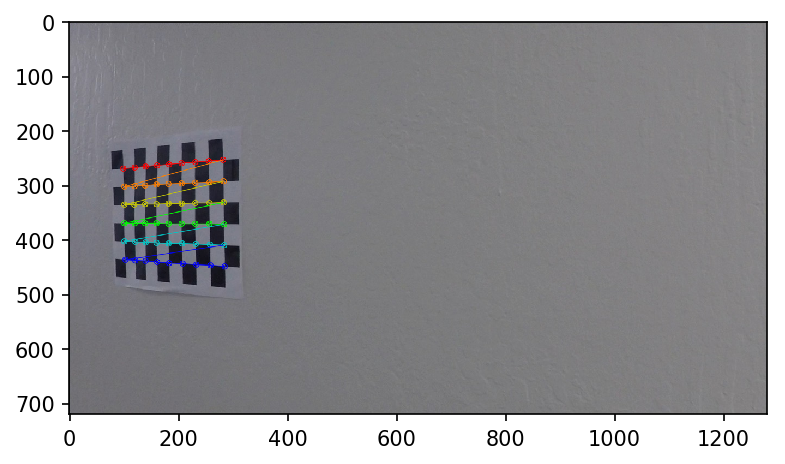

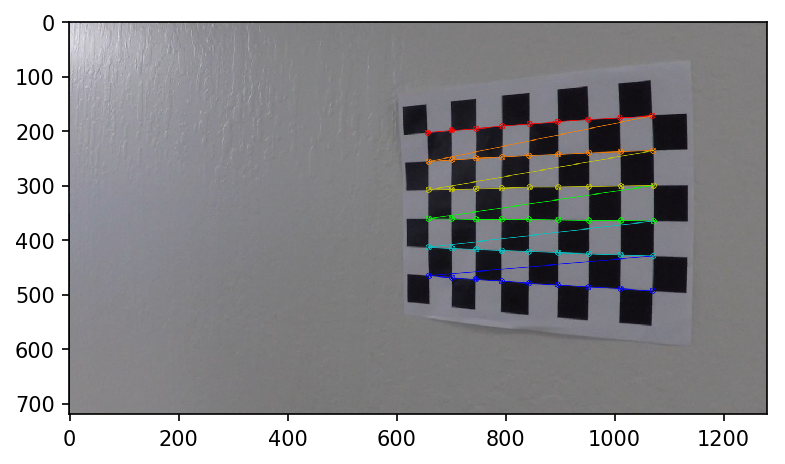

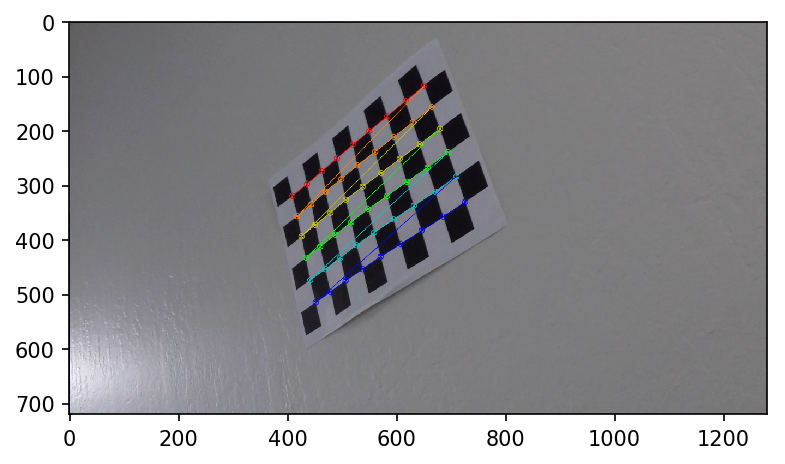

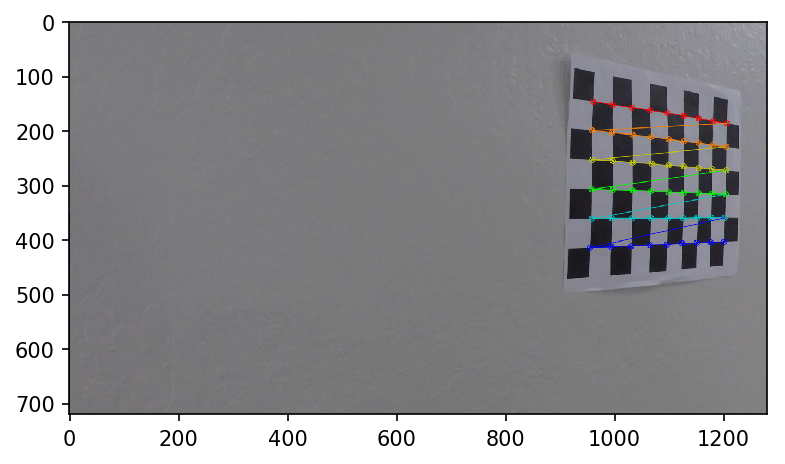

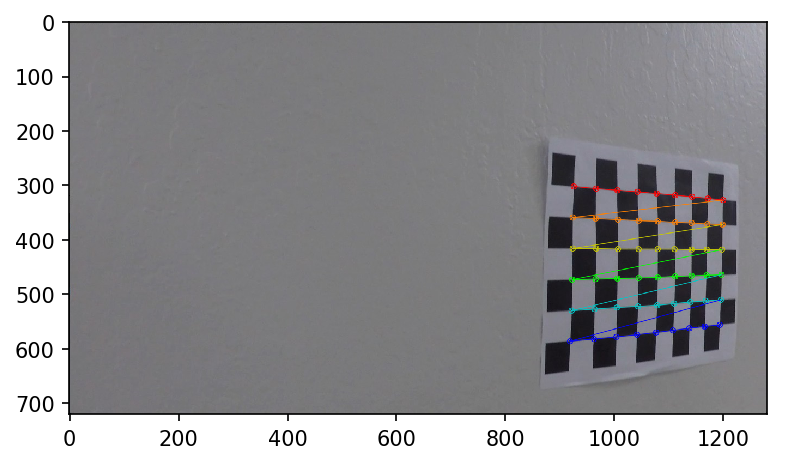

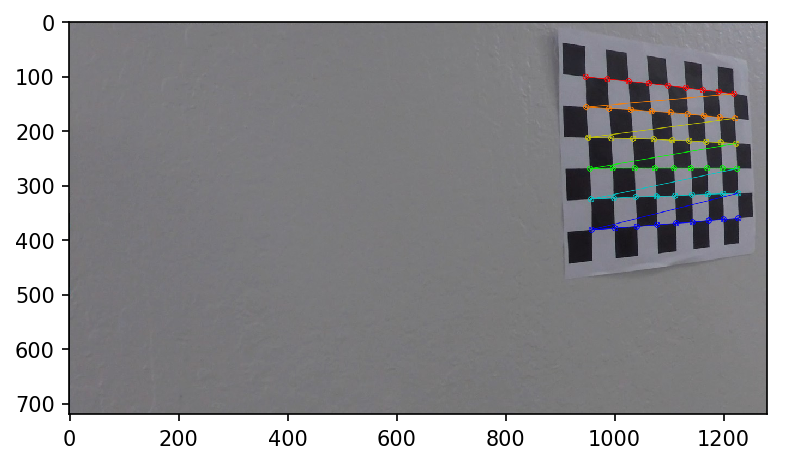

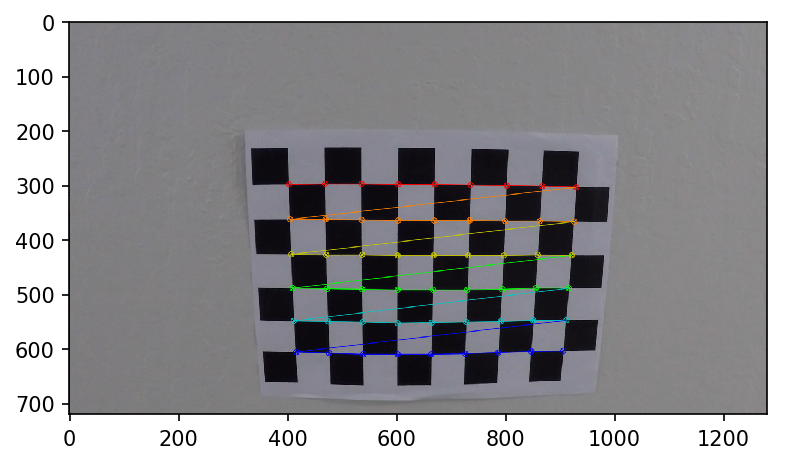

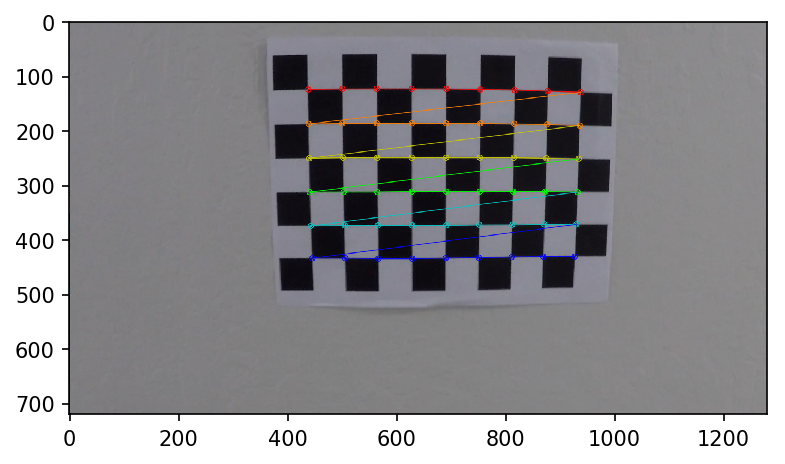

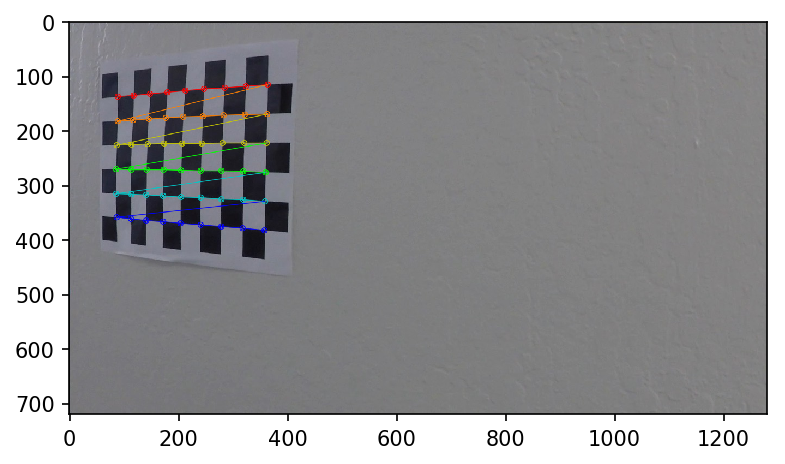

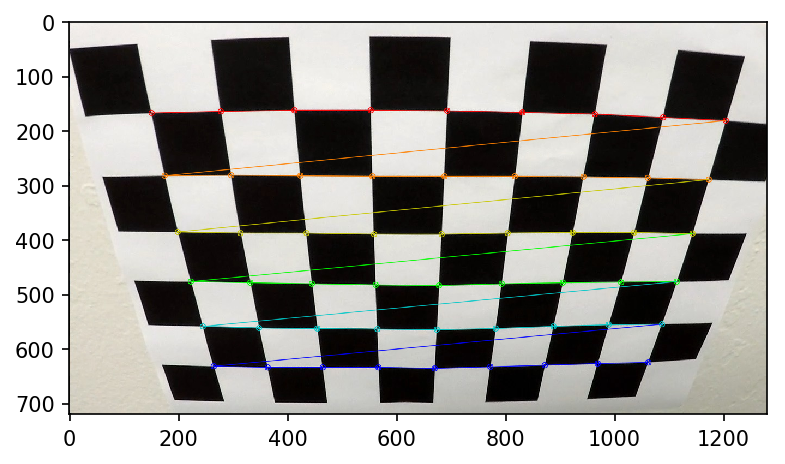

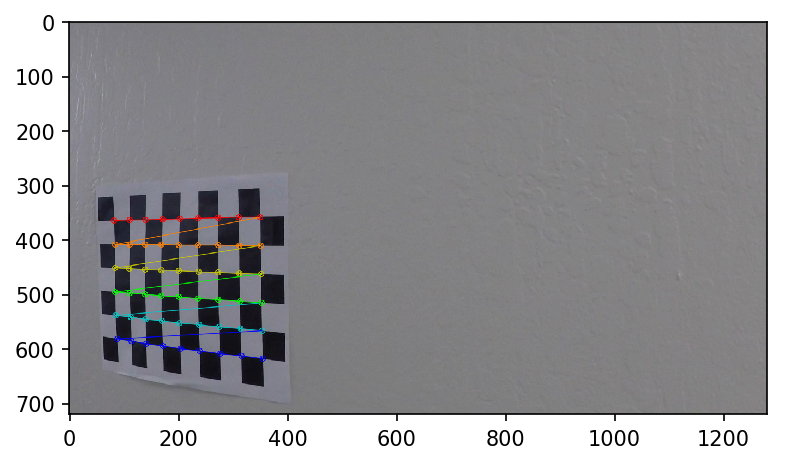

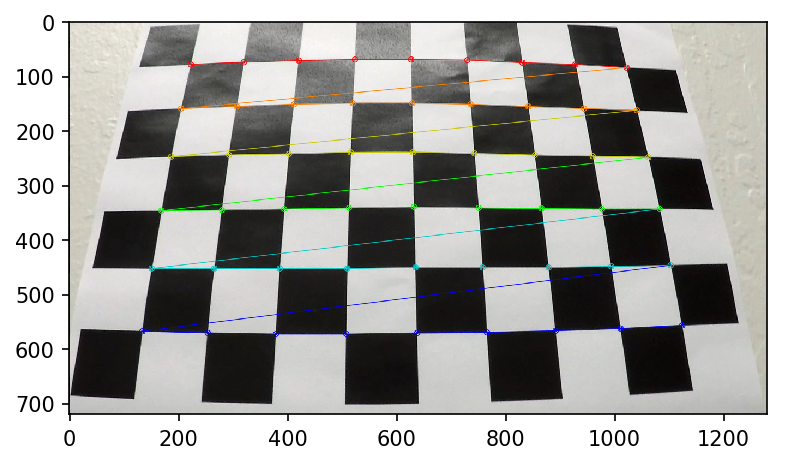

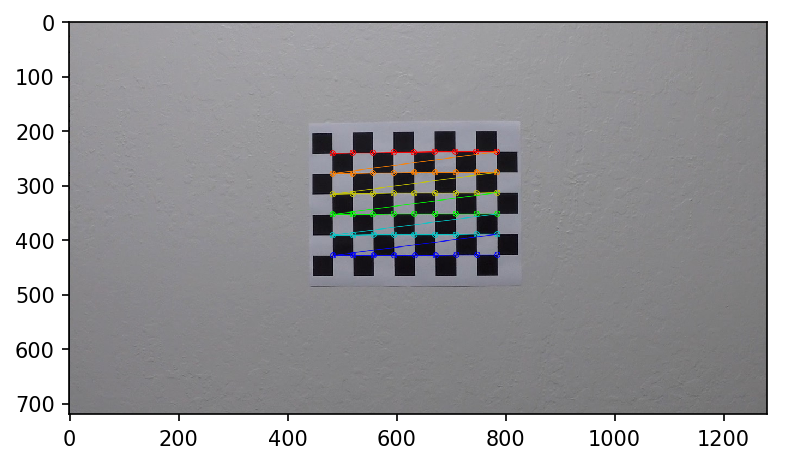

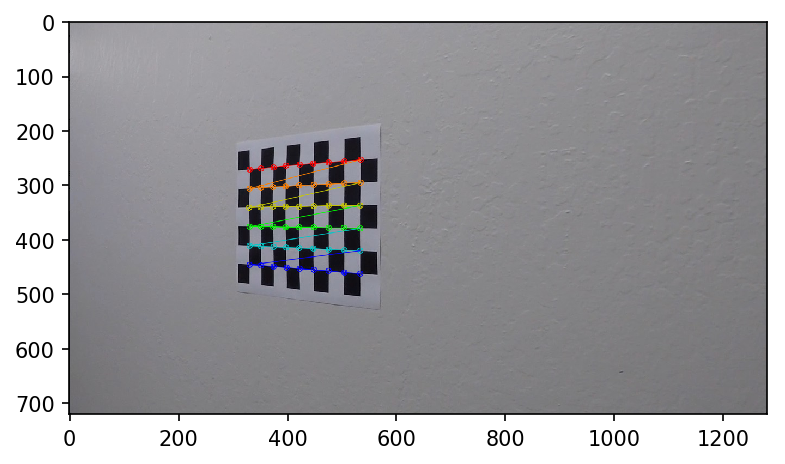

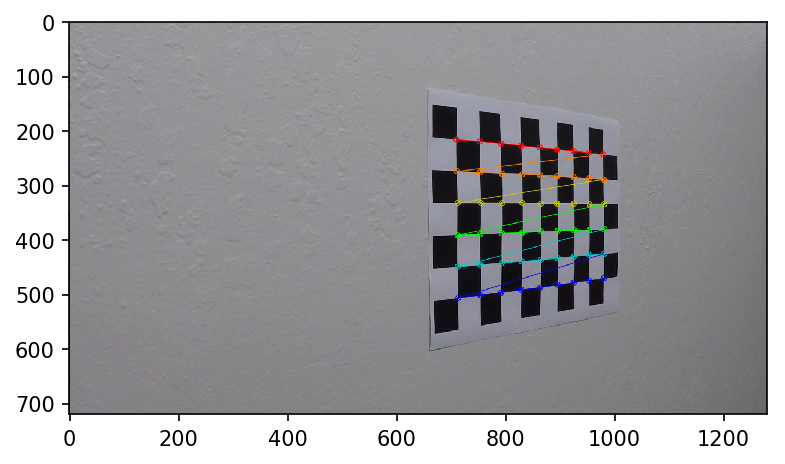

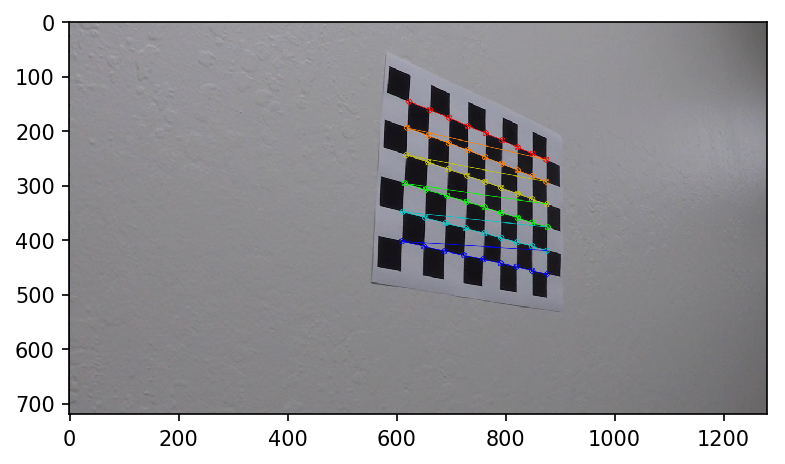

In [4]:
ret, mtx, dist, rvecs, tvecs = calibrate()

In [5]:
def region_of_interest(img):
    vertices = np.array([[
    (0, img.shape[0]-1),
    (img.shape[1] // 2,img.shape[0] // 2),
    (img.shape[1]-1, img.shape[0]-1),
    ]], dtype = np.int32)
    mask = np.zeros_like(img)
    match_mask_color = 255
    cv2.fillPoly(mask, vertices, match_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
def get2pts(line, isp):
    if(isp):
        return line
    
    rho, theta = line
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    return int(x0 + 1000*(-b)), int(y0 + 1000*(a)), int(x0 - 1000*(-b)), int(y0 - 1000*(a))

In [7]:
def getnormal(line, isp):
    if(isp):
        x1, y1, x2, y2=line
        dx, dy = x2-x1, y2-y1
        norm = np.sqrt(dx**2+dy**2)
        return -dy/norm, dx/norm

    rho, theta = line
    return np.cos(theta), np.sin(theta)

In [8]:
def calculate_vanishing_point(img):
    low_thresh = 100
    high_thresh = 200
    ud_img = undistort(img , mtx ,  dist)
    ud_img = np.array(img)
    gray = cv2.cvtColor(ud_img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(11,11),0)
    edges = cv2.Canny(gray,low_thresh,high_thresh,apertureSize = 3)
    edges = region_of_interest(edges)
    #lines = cv2.HoughLines(edges,1,np.pi/180,250)
    lines = cv2.HoughLinesP(
        edges,
        rho=2,
        theta=np.pi / 180,
        threshold=50,
        lines=np.array([]),
        minLineLength=10,
        maxLineGap=120
    )
    
    
    t1 = np.zeros((2,2) , dtype=np.float)
    t2 = np.zeros((2,1) , dtype= np.float)
        
    for line in lines:
        
        a,b = getnormal(line[0], True)
        x1, y1, x2, y2 = get2pts(line[0], True)

        n = np.array([[a],[b]] , dtype=np.float)
        n_x_nt = np.matmul(n , np.transpose(n))
        p = np.array([[x1],[y1]] , dtype= np.float)
        t1 += n_x_nt
        t2 += np.matmul(n_x_nt , p)

        cv2.line(ud_img,(x1,y1),(x2,y2),(0,0,255),2)
            
            
    vp = np.matmul(np.linalg.pinv(t1),t2)
    vp = np.array(vp , dtype = np.int)
    print(vp)
    
    cv2.line(ud_img,(vp[0,0],vp[1,0]),(vp[0,0],vp[1,0]),(255,0,0),20)
            
    
    display(cv2.cvtColor(ud_img, cv2.COLOR_BGR2RGB), False)
    return vp

In [9]:
def find_x(p1, p2, y):
    y1, y2, x1, x2 = p1[1], p2[1], p1[0], p2[0]
    return (y-y1) * ((x2-x1) / (y2-y1)) + x1

In [10]:
def display_trapezoid(img_orig, p1, p2, p3, p4, vp):
    img = np.array(img_orig)
    
    cv2.line(img,(p1[0],p1[1]),(p3[0],p3[1]),(255,0,0), 5)
    cv2.line(img,(p2[0],p2[1]),(p4[0],p4[1]),(255,0,0), 5)
    cv2.line(img,(p2[0],p2[1]),(p1[0],p1[1]),(255,0,0), 5)
    cv2.line(img,(p3[0],p3[1]),(p4[0],p4[1]),(255,0,0), 5)
    cv2.line(img,(vp[0,0],vp[1,0]),(vp[0,0],vp[1,0]),(255,0,0),20)
    
    display(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False)

In [11]:
def perspective_transform(img):
    vp = calculate_vanishing_point(img)
    y_base = img.shape[0]-100
    x_off, y_off =  150, 65 
    p1, p2 = [vp[0,0]-x_off, vp[1, 0]+y_off], [vp[0,0]+x_off, vp[1, 0]+y_off]
    p3, p4 = [find_x(p1, [vp[0, 0], vp[1, 0]], y_base), y_base], [find_x(p2, [vp[0, 0], vp[1, 0]], y_base), y_base]
    ps = [p1, p2, p3, p4]
    for p in ps:
        p[0], p[1] = int(p[0]), int(p[1])
            
    display_trapezoid(img, p1, p2, p3, p4, vp)
            
    map_size = (300, 600)
    src = np.float32([p1, p2, p3, p4])
    dst = np.float32([[0,0], [map_size[0]-1, 0], [0, map_size[1]-1], [map_size[0]-1, map_size[1]-1]])
    H, H_inv = cv2.getPerspectiveTransform(src, dst), cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, H, map_size)
    
    display(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), False)
    
    return H, H_inv, warped 

In [12]:
def get_ratio(img):
    meter_to_feet = 1/3.28084
    low_thresh = 100
    high_thresh = 200
    H, H_inv, warped = perspective_transform(img)
    
    gray = cv2.cvtColor(warped,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray,(3,3),0)
    edges = cv2.Canny(gray,low_thresh,high_thresh,apertureSize = 3)
    display(edges, True)
    #lines = cv2.HoughLines(edges,1,np.pi/180,100)
    lines = cv2.HoughLinesP(
        edges,
        rho=2,
        theta=np.pi / 180,
        threshold=50,
        lines=np.array([]),
        minLineLength=10,
        maxLineGap=120
    )
    
    x_min = img.shape[1]
    x_max = 0
    
    for line in lines:
        x1, y1, x2, y2 = get2pts(line[0], True)

        if(x1 < x_min):
            x_min = x1
        if(x1 > x_max):
            x_max = x1

        cv2.line(warped,(x1,y1),(x2,y2),(0,0,255),2)
    
    display(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB), False)
    approx_dist = x_max - x_min
    x_pixels_per_meter = approx_dist / (12 * meter_to_feet)
    
    inv_H_x_mtx = np.linalg.inv(np.matmul(H , mtx))
    x_norm = np.linalg.norm(inv_H_x_mtx[:,0])
    y_norm = np.linalg.norm(inv_H_x_mtx[:,1])
    scale = x_norm / y_norm
    y_pixels_per_meter = x_pixels_per_meter * scale
    
    return x_pixels_per_meter , y_pixels_per_meter, H

In [13]:
def get_distance(pxl1, pxl2, H, x_ratio, y_ratio):
    mapped_pxl1 = cv2.perspectiveTransform(np.float32([[pxl1]]), H)[0][0]
    mapped_pxl2 = cv2.perspectiveTransform(np.float32([[pxl2]]), H)[0][0]
    x_pxl_dis, y_pxl_dis = mapped_pxl1[0]-mapped_pxl2[0], mapped_pxl1[1]-mapped_pxl2[1]
    x_mtr_dis, y_mtr_dis = x_pxl_dis/x_ratio, y_pxl_dis/y_ratio
    return np.sqrt(x_mtr_dis**2 + y_mtr_dis**2)

In [14]:
def distance_estimation_driver():
    #getratios
    #img = cv2.imread('straight_lines1.jpg')
    #img = cv2.imread('x.jpeg')
    img = cv2.imread('x5.png')
    x_ratio, y_ratio, H = get_ratio(img)
    
    #dis
    query_pxls = [[410, 500], [800, 500], [700, 450]]
    cols = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    colstr = ['Blue', 'Green', 'Red']
    center = [img.shape[1]//2, img.shape[0]-1]
    for i in range(len(query_pxls)):
        print('distance to '+str(query_pxls[i])+': '+str(get_distance(query_pxls[i], center, H, x_ratio, y_ratio))
             +' with color '+str(colstr[i]))
        cv2.line(img, (query_pxls[i][0], query_pxls[i][1]),(query_pxls[i][0], query_pxls[i][1]),cols[i],20)
    display(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False)

[[657]
 [421]]


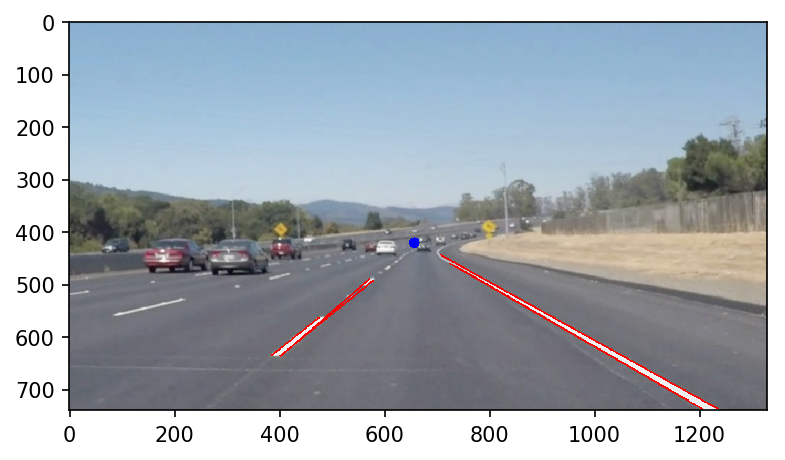

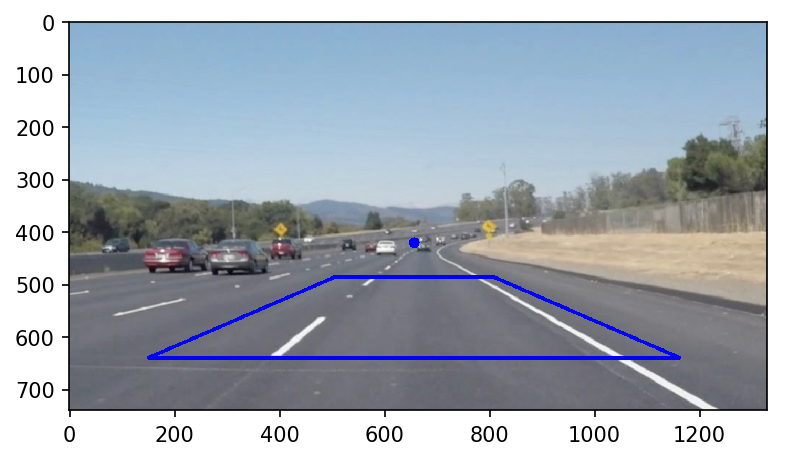

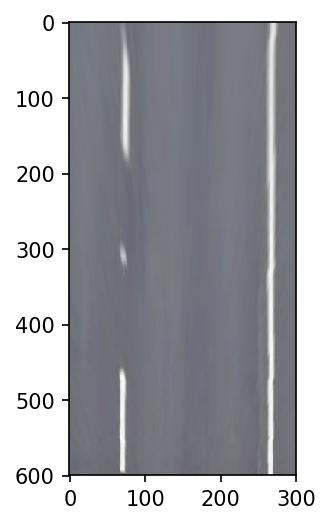

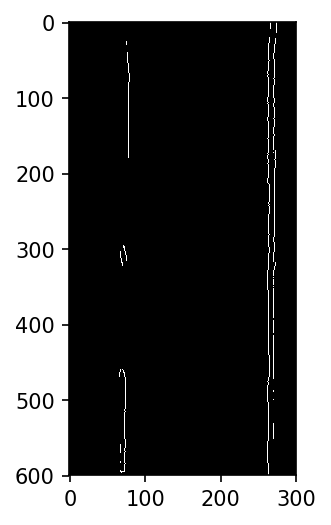

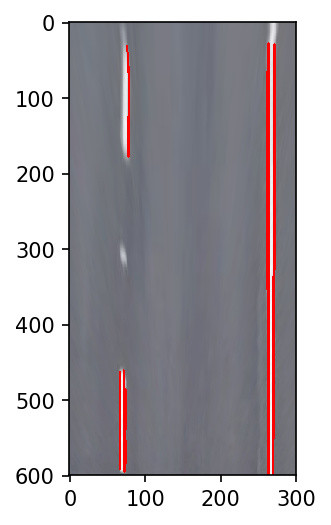

distance to [410, 500]: 13.303165310532837 with color Blue
distance to [800, 500]: 12.957133821071686 with color Green
distance to [700, 450]: 42.184012513084824 with color Red


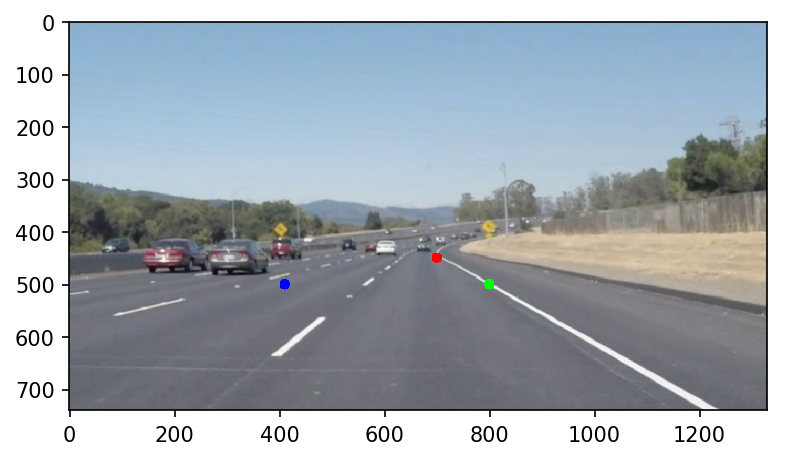

In [15]:
distance_estimation_driver()